# Attempt to compare the original lotka-voltera equations with a discrte and binomial birth one




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from random import random
import matplotlib
from netCDF4 import Dataset
import matplotlib.cm as cm
import matplotlib.pyplot as plt    # The code below assumes this convenient renaming
import math
import seaborn as sns
sns.set()

import sys 
import pandas as pd

from binomial_function_collection import *

# modifying my original predator prey setup to act more like a discrete lotka voltera system

In [2]:
def func_timestepping_lotvol(N,a,b,c,d):
    """
    Runs timestepping, but needs everything to have already been defined previously in the settings cell.
    
    Mimics a very crude version of the predator prey model, where small objects (rabbits) are spawned randomly, but the more accumulate the higher the chance is of attracting a big objects (wolves) that eat a rabbit each time. 
    
    To sort out the order: 
    
    1. Object birthdays
    2. Births!
    3. Apply births
    4. Eat and starve as should be
    
    Has discrete death (through demographics)
    """
    #--- time loop ----
    for t in range(1,ntim):
        #print('timestep start:',t,', rabbits:',np.sum(N[:,:,0,t,:]),', wolfs:',np.sum(N[:,:,1,t,:]))

                
        #--- Object birthdays! Time-shift of the demographics levels ---
        for l in range(2):
            if t>0:
                for i in range(nage-1,0,-1):
                    #print("t=%s  l:%s  i:%s  max N:%s" % (t, l, i, np.max(N[:,:,l,t-1,i])) )
                    N[:,:,l,t,i] = N[:,:,l,t-1,i-1]   #note: oldest level is forgotten
            else:
                #
                print('no ageing first timestep')
                #N[:,:,l,0,1] = N[:,:,l,0,0]   #note: bodge for dealine with how I set the initial conditions
        
        #print('timestep post aging:',t,', rabbits:',np.sum(N[:,:,0,t,:]),', wolfs:',np.sum(N[:,:,1,t,:]))
        #print('rabbits post age:',N[0,0,0,0,:])
        #print('rabbits post age:',N[0,0,0,1,:])
        
        #--- Determine wolf birthrate, 
        #Wolf birthrate analystical
        wolf_birth_grid = d*b*np.sum(N[:,:,0,t,:],axis=2).ravel() * np.sum(N[:,:,1,t,:],axis=2).ravel() 
        #total births on ref domain
        wolf_birth_total_ref = ((wolf_birth_grid*L_ref*L_ref/dx/dy)*dtim).astype(int)
        N_tot_ref[:,:,1] = wolf_birth_total_ref.reshape([nx,ny])
        
        #--- Determine rabbit birthrate, 
        #Rabbit birthrate analystical
        rabbit_birth_grid = a*np.sum(N[:,:,0,t,:],axis=2).ravel() 
        #total births on ref domain
        rabbit_birth_total_ref = ((rabbit_birth_grid*L_ref*L_ref/dx/dy)*dtim).astype(int)
        N_tot_ref[:,:,0] = rabbit_birth_total_ref.reshape([nx,ny])
        
        #print('min new rabbit:',np.min(N_tot_ref[:,:,0]),'min new wolf:',np.min(N_tot_ref[:,:,1]))
        #print('min rabbit:',np.min(np.sum(N[:,:,0,t,:],axis=2).ravel()))
        if np.min(N_tot_ref[:,:,0])<0:
            print(N_tot_ref,a,N[:,:,0,t,:])
        #wolf_birth = np.sum(N[:,:,0,t,:],axis=2).ravel() * p[:,:,0,t].ravel()*ratio_birth
        #wolf_birth[np.where(wolf_birth>1)[0]]=0.99
        #wolf_birth[np.where(wolf_birth<0)[0]]=0.
        #p[:,:,1,t] = wolf_birth.reshape([nx,ny])
        
        
        
        #--- Calculate and apply birhts for both species ---
        for l in range(2):

            
            #--- Births ---
            B = np.random.binomial(N_tot_ref[:,:,l].ravel(), p[:,:,l,t].ravel(), nx*ny)
            B = B.reshape([nx,ny])
            # Warning! Need to make sure that the resizing is done correctly, so that x and y aren't swapped accidentally
            #if l ==0:
            #    print('rabbits born = ',np.sum(B))
            #if l ==1:
            #    print('wolfs born = ',np.sum(B))
            
            #--- Update object number: add births as level 1 demographics ---
            #print('births for size l:',l,B)
            N[:,:,l,t,0] = B   # add births 
            
        #print('timestep post birth:',t,', rabbits:',np.sum(N[:,:,0,t,:]),', wolfs:',np.sum(N[:,:,1,t,:]))
        
        
        
        
        
        
        
        #--- predation, this is a bit trickier than birth ---
        #rabbit eaten analytical
        rabbit_eaten_grid = b*np.sum(N[:,:,0,t,:],axis=2).ravel() * np.sum(N[:,:,1,t,:],axis=2).ravel() 
        #rabbit eaten discrete on ref domain
        rabbit_eaten_ref_total =  ((rabbit_eaten_grid*L_ref*L_ref/dx/dy)*dtim).astype(int)
        #Cacluating rabits eaten on each grid cell using binomial trial
        rabbits_eaten = (np.random.binomial(rabbit_eaten_ref_total.ravel(), p[:,:,l,t].ravel(), nx*ny)).reshape([nx,ny])
        
        #rabbits_eaten     = np.sum(N[:,:,1,t,:],axis=2)
        #diff_wolf_rabbits = np.sum(N[:,:,1,t,:],axis=2)-np.sum(N[:,:,0,t,:],axis=2)
        
        #Ok, I am struggling to make this work nicely, so for now I will do it box by box, and will make it nice later
            
        for i in range(nx):
            for j in range(ny):
                #--- Update object number: remove each eaten rabbit from a random age group ---
            
                for w in range(rabbits_eaten[i,j]):
                    total_rabbits_now = np.sum(N[i,j,0,t,:])
                    if total_rabbits_now>0:
                        #randomly select the rabbit to die
                        dead_wabbit = np.random.randint(total_rabbits_now)+1 
                        #use searchsorted and cumsum to check which rabbit was eaten
                        age_dead_wabbit = np.searchsorted(np.cumsum(N[i,j,0,t,:]),dead_wabbit)
                         
                        #revomve rabbit
                        N[i,j,0,t,age_dead_wabbit] -= 1
                        if N[i,j,0,t,age_dead_wabbit] <0:
                            print('here is where things go wrong')
                            print(np.cumsum(N[i,j,0,t,:]))
                            print(total_rabbits_now,dead_wabbit,age_dead_wabbit,rabbits_eaten[i,j],N[i,j,0,t,:])
                            print(not_defined)
                        
          
        #--- wolf deaths, also for now just assumed to be taken from a random age
        
        #wolfs died analytical
        wolf_dead_grid = c*np.sum(N[:,:,1,t,:],axis=2).ravel()  
        #rabbit eaten discrete on ref domain
        wolf_dead_ref_total =  ((wolf_dead_grid*L_ref*L_ref/dx/dy)*dtim).astype(int)
        #Cacluating rabits eaten on each grid cell using binomial trial
        wolfs_dead = (np.random.binomial(wolf_dead_ref_total.ravel(), p[:,:,l,t].ravel(), nx*ny)).reshape([nx,ny])
        
        
        #Ok, I am struggling to make this work nicely, so for now I will do it box by box, and will make it nice later
            
        for i in range(nx):
            for j in range(ny):
                #--- Update object number: remove each dead wolf from a random age group ---
            
                for w in range(wolfs_dead[i,j]):
                    total_wolfs_now = np.sum(N[i,j,1,t,:])
                    if total_wolfs_now>0:
                        #randomly select the wolf to die
                        dead_wolf = np.random.randint(total_wolfs_now)+1 
                        #use searchsorted and cumsum to check which wolf died
                        age_dead_wolf = np.searchsorted(np.cumsum(N[i,j,1,t,:]),dead_wolf)
                         
                        #revomve wolf
                        N[i,j,1,t,age_dead_wolf] -= 1
                        if N[i,j,1,t,age_dead_wolf] <0:
                            print('here is where things go wrong')
                            print(np.cumsum(N[i,j,0,t,:]))
                            print(not_defined)
        print('timestep:',t,', rabbits:',np.sum(N[:,:,0,t,:]),', wolfs:',np.sum(N[:,:,1,t,:]),', rabbits eaten:',np.sum(rabbits_eaten),' wolfs dead:',np.sum(wolfs_dead))
        print('timestep:',t,', new rabbits:',np.sum(N[:,:,0,t,0]),', new wolfs:',np.sum(N[:,:,1,t,0]))
    return N


In [3]:
#

#--- Grid parameters ----------
nx   = 36    #grid size
ny   = 1

nsiz = 2       #nr of sizes in spectrum

#ntim = 10     #nr of timesteps
ntim = 150   #nr of timesteps 

nage = 1        #dimension of thermal demographics: number of thermal age strata

dx   = 10.    #x gridspacing     [km]
dy   = 10.     #y gridspacing    [km]
dsiz = 10.    #width of size bin [km]
dtim = 1./10     #time increment    [d]

#--- Reference domain
L_ref    = 50.   #size of very large reference domain  [km]
dt_ref   = dtim       #timestep of very large ref domain    [s]

#--- birth and lifetime constants --------

tau_D     = dtim*ntim   #object life time  [m]
#tau_D     = 150.    #object life time  [m]
tau_D_dt  = int(tau_D/dtim) #object life time in timesteps []

nage = int(tau_D/dtim)   #demographics: number of object age strata


# #--- Advection parameters
# u  = 5. #x wind, used for advection [m/s]
# v  = 5. #y wind, used for advection [m/s]

#lotka voltera parameters, devided by 12:


a = 1.   
c = 1.5  
d = 0.75 

b = 0.03  

print('stationary conditons',  c/(d*b), a/b)


#--- declare arrays -----------
x    = ( np.array(range(nx  )) + 0.5) * dx
y    = ( np.array(range(ny  )) + 0.5) * dy
siz  = ( np.array(range(nsiz)) + 0.5) * dsiz
tim  = ( np.array(range(ntim)) + 0.5) * dtim

N        = np.zeros( (nx,ny,nsiz,ntim,nage) ).astype(int)    #array containing object number
p        = np.empty( (nx,ny,nsiz,ntim) )    #array containing object birth probability


#starting population size of wolfs and foxes
N[:,:,0,0,0]=64#50
N[:,:,1,0,0]=16#15

#--- binomial probability values -----------
N_tot_ref = np.zeros((nx,ny,nsiz)).astype(int)

prob_sub = dx*dy*dtim/(dt_ref*L_ref*L_ref)     #probability that one of N_tot_ref births happens in a gridbox
print( "prob_sub=%s" % (prob_sub) )

p[:,:,:,:] = prob_sub

np.random.seed(0)

stationary conditons 66.66666666666667 33.333333333333336
prob_sub=0.04


In [4]:
N= func_timestepping_lotvol(N,a,b,c,d)

timestep: 1 , rabbits: 2424 , wolfs: 565 , rabbits eaten: 127  wolfs dead: 88
timestep: 1 , new rabbits: 236 , new wolfs: 62
timestep: 2 , rabbits: 2516 , wolfs: 545 , rabbits eaten: 137  wolfs dead: 112
timestep: 2 , new rabbits: 213 , new wolfs: 78
timestep: 3 , rabbits: 2613 , wolfs: 526 , rabbits eaten: 143  wolfs dead: 93
timestep: 3 , new rabbits: 227 , new wolfs: 57
timestep: 4 , rabbits: 2717 , wolfs: 514 , rabbits eaten: 150  wolfs dead: 88
timestep: 4 , new rabbits: 244 , new wolfs: 66
timestep: 5 , rabbits: 2808 , wolfs: 526 , rabbits eaten: 148  wolfs dead: 85
timestep: 5 , new rabbits: 226 , new wolfs: 82
timestep: 6 , rabbits: 2952 , wolfs: 520 , rabbits eaten: 133  wolfs dead: 99
timestep: 6 , new rabbits: 263 , new wolfs: 80
timestep: 7 , rabbits: 3103 , wolfs: 525 , rabbits eaten: 162  wolfs dead: 89
timestep: 7 , new rabbits: 289 , new wolfs: 84
timestep: 8 , rabbits: 3247 , wolfs: 540 , rabbits eaten: 176  wolfs dead: 96
timestep: 8 , new rabbits: 300 , new wolfs: 92

# Plotting

In [5]:
N_over_time = np.sum(N,axis=4)
N_over_time_total = np.sum(N_over_time,axis=0)
N_over_time_total = np.sum(N_over_time_total,axis=0)
N_median_over_time = (np.percentile(N_over_time,50,axis=0))[0,:,:]

(0.5, 1000)

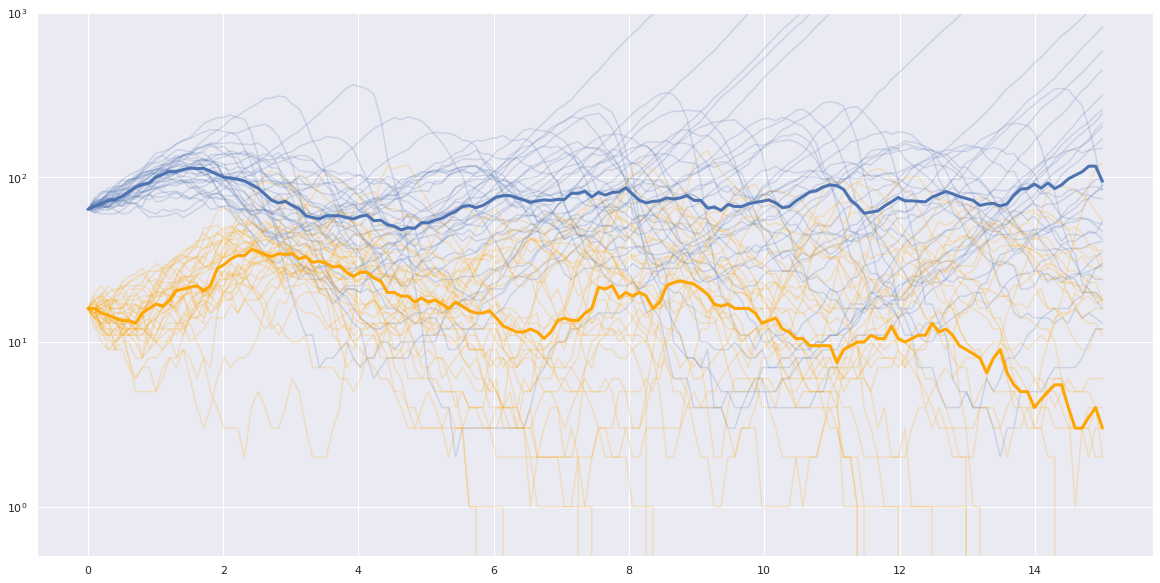

In [6]:
fig,axes = plt.subplots(1,1,figsize=(20,10))
t = np.linspace(0, 15,  150)    
for i in range(nx):
    for j in range(ny):
        axes.plot(t,N_over_time[i,j,0],'b',alpha=0.2)
        axes.plot(t,N_over_time[i,j,1],'orange',alpha=0.2)
#plt.plot(t,N_over_time_total[0]/nx/ny,'b',linewidth=3)
#plt.plot(t,N_over_time_total[1]/nx/ny,'orange',linewidth=3)
plt.plot(t,N_median_over_time[0,:],'b',linewidth=3)
plt.plot(t,N_median_over_time[1,:],'orange',linewidth=3)
plt.yscale('log')
plt.ylim([0.5,1000])

# Analytical version taken from scipy cookbook


du/dt =  a*u -   b*u*v  
dv/dt = -c*v + d*b*u*v

*  u: number of preys (for example, rabbits)

*  v: number of predators (for example, foxes)  
  
* a, b, c, d are constant parameters defining the behavior of the population:    

  + a is the natural growing rate of rabbits, when there's no fox

  + b is the natural dying rate of rabbits, due to predation

  + c is the natural dying rate of fox, when there's no rabbit

  + d is the factor describing how many caught rabbits let create a new fox

We will use X=[u, v] to describe the state of both populations.

Definition of the equations:

In [7]:
def dX_dt(X, t=0):
    """ Return the growth rate of cat and rat populations. """
    return np.array([ a*X[0] -   b*X[0]*X[1] ,
                  -c*X[1] + d*b*X[0]*X[1] ])

In [8]:
#!python
from scipy import integrate
t = np.linspace(0, 15,  1500)              # time
t_ana = t
X0 = np.array([50, 15])                     # initials conditions: 10 rabbits and 5 foxes
X0 = np.array([64, 16])                     # initials conditions: 10 rabbits and 5 foxes
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'
rats, cats = X.T


# plotting both

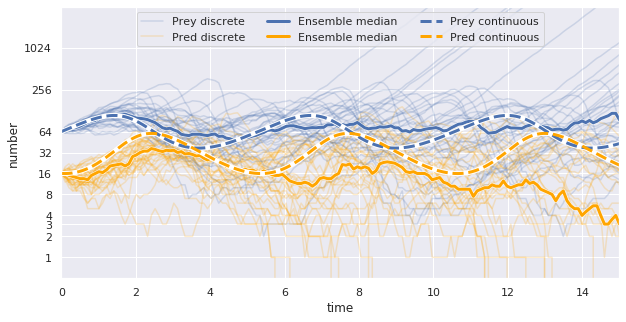

In [9]:
fig,axes = plt.subplots(1,1,figsize=(10,5))
t = np.linspace(0, 15,  150)    
for i in range(1,nx):
    for j in range(ny):
        axes.plot(t,N_over_time[i,j,0],'b'     ,alpha=0.2,linewidth=1.5)
        axes.plot(t,N_over_time[i,j,1],'orange',alpha=0.2,linewidth=1.5)
axes.plot(t,N_over_time[0,0,0],'b'             ,alpha=0.2,linewidth=1.5,label='Prey discrete')
axes.plot(t,N_over_time[0,0,1],'orange'        ,alpha=0.2,linewidth=1.5,label='Pred discrete')
plt.plot(t,N_median_over_time[0,:],'w',linewidth=4)
plt.plot(t,N_median_over_time[1,:],'w',linewidth=4)
plt.plot(t,N_median_over_time[0,:],'b'     ,linewidth=3,label='Ensemble median')
plt.plot(t,N_median_over_time[1,:],'orange',linewidth=3,label='Ensemble median')
plt.yscale('log')
plt.ylim([0.5,4000])
plt.xlim([0.,15])
plt.xlabel('time')
plt.ylabel('number')


plt.plot(t_ana, rats, 'w',   linewidth=5)
plt.plot(t_ana, cats  , 'w', linewidth=5)
plt.plot(t_ana, rats, 'b', linewidth=3  ,linestyle='--',label='Prey continuous')
plt.plot(t_ana, cats  , 'orange', linewidth=3  ,linestyle='--',label='Pred continuous')
plt.legend(ncol=3,loc='upper center')


#axes.set_xticks(siz[[0,1,2,3,5,9]])
#axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#axes.set_yticks([int(1),2,3,4,8,16,2**5,4**3,2**7,4**4,2**9])
axes.set_yticks([int(1),2,3,4,8,16,2**5,4**3,4**4,2**10])
axes.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


#fig.savefig('fig/lotka_voltera_digital_vs_analog_0515.pdf',bbox_inches='tight')

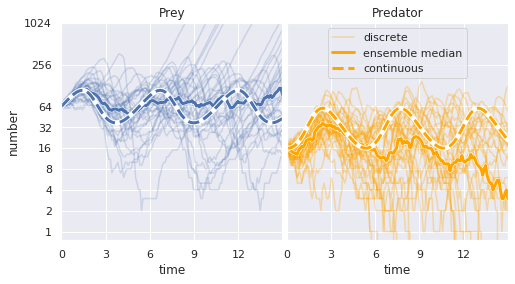

In [11]:
fig,axes = plt.subplots(1,2,figsize=(8,4),sharey=True,sharex=True)
t = np.linspace(0, 15,  150)    
for i in range(1,nx):
    for j in range(ny):
        axes[0].plot(t,N_over_time[i,j,0],'b'     ,alpha=0.2,linewidth=1.5)
        axes[1].plot(t,N_over_time[i,j,1],'orange',alpha=0.3,linewidth=1.5)
axes[0].plot(t,N_over_time[0,0,0],'b'             ,alpha=0.2,linewidth=1.5,label='discrete')
axes[1].plot(t,N_over_time[0,0,1],'orange'        ,alpha=0.3,linewidth=1.5,label='discrete')
axes[0].plot(t,N_median_over_time[0,:],'w',linewidth=4)
axes[1].plot(t,N_median_over_time[1,:],'w',linewidth=4)
axes[0].plot(t,N_median_over_time[0,:],'b'     ,linewidth=3,label='ensemble median')
axes[1].plot(t,N_median_over_time[1,:],'orange',linewidth=3,label='ensemble median')
axes[0].set_yscale('log')
axes[0].set_ylim([0.75,1024])
axes[0].set_xlim([0.,15])
axes[0].set_xlabel('time')
axes[1].set_xlabel('time')
axes[0].set_ylabel('number')

axes[0].set_title('Prey')
axes[1].set_title('Predator')

axes[0].plot(t_ana, rats, 'w',   linewidth=5)
axes[1].plot(t_ana, cats  , 'w', linewidth=5)
axes[0].plot(t_ana, rats, 'b', linewidth=3  ,linestyle='--'       ,label='continuous')
axes[1].plot(t_ana, cats  , 'orange', linewidth=3  ,linestyle='--',label='continuous')
axes[1].legend(ncol=1,loc='upper center')


#axes.set_xticks(siz[[0,1,2,3,5,9]])
#axes.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#axes.set_yticks([int(1),2,3,4,8,16,2**5,4**3,2**7,4**4,2**9])
axes[0].set_yticks([int(1),2,4,8,16,2**5,4**3,4**4,2**10])
axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axes[0].set_xticks([int(0),3,6,9,12])

plt.subplots_adjust(wspace=0.02)



In [12]:
fig.savefig('fig/predprey_0520.pdf',bbox_inches='tight')

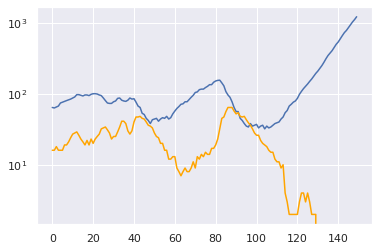

In [15]:
# Total amount over all cells

N_over_time = np.sum(N,axis=4)
plt.plot(N_over_time[0,0,0,:],'b')
plt.plot(N_over_time[0,0,1,:],'orange')
plt.yscale('log')
#plt.plot(N_over_time_total[1],'orange')

# lets look at age distribution 


In [25]:
#only looking up to a specific timestep
t_max = 50
N_by_age = np.sum(N[:,:,:,:t_max,:],axis=3)
N_by_age = np.sum(N_by_age,axis=0)
N_by_age = np.sum(N_by_age,axis=0)


Text(0, 0.5, 'number')

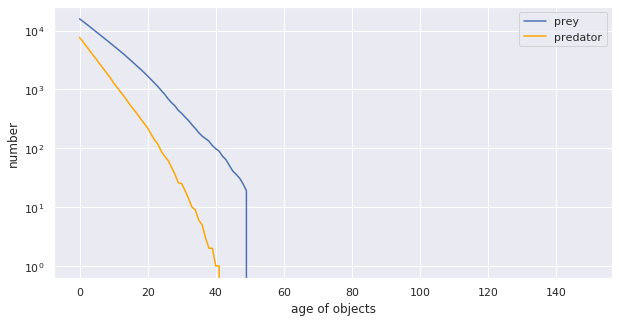

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(N_by_age[0,:],'b',label='prey')
ax.plot(N_by_age[1,:],'orange',label='predator')
plt.legend()
ax.set_yscale('log')
ax.set_xlabel('age of objects')
ax.set_ylabel('number')

## look at single timestep

In [29]:
#only looking up to a specific timestep
t_max = 100
N_by_age = N[:,:,:,t_max,:]
N_by_age = np.sum(N_by_age,axis=0)
N_by_age = np.sum(N_by_age,axis=0)


Text(0, 0.5, 'number')

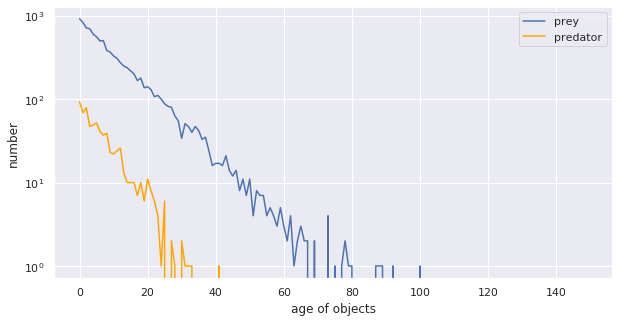

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(N_by_age[0,:],'b',label='prey')
ax.plot(N_by_age[1,:],'orange',label='predator')
plt.legend()
ax.set_yscale('log')
ax.set_xlabel('age of objects')
ax.set_ylabel('number')